Historical Data:
    year_numeric  students     year
0           1999    514723  1999/00
1           2000    547868  2000/01
2           2001    582994  2001/02
3           2002    586323  2002/03
4           2003    572509  2003/04
5           2004    565039  2004/05
6           2005    564766  2005/06
7           2006    582984  2006/07
8           2007    623805  2007/08
9           2008    671616  2008/09
10          2009    690923  2009/10
11          2010    723277  2010/11
12          2011    764495  2011/12
13          2012    819644  2012/13
14          2013    886052  2013/14
15          2014    974926  2014/15
16          2015   1043839  2015/16
17          2016   1078822  2016/17
18          2017   1094792  2017/18
19          2018   1095299  2018/19
20          2019   1075496  2019/20
21          2020    914095  2020/21
22          2021    948519  2021/22
23          2022   1057188  2022/23

Linear Model - RMSE: 78641.19, R²: 0.8571
Polynomial Model - RMSE: 78623.25, R²: 0

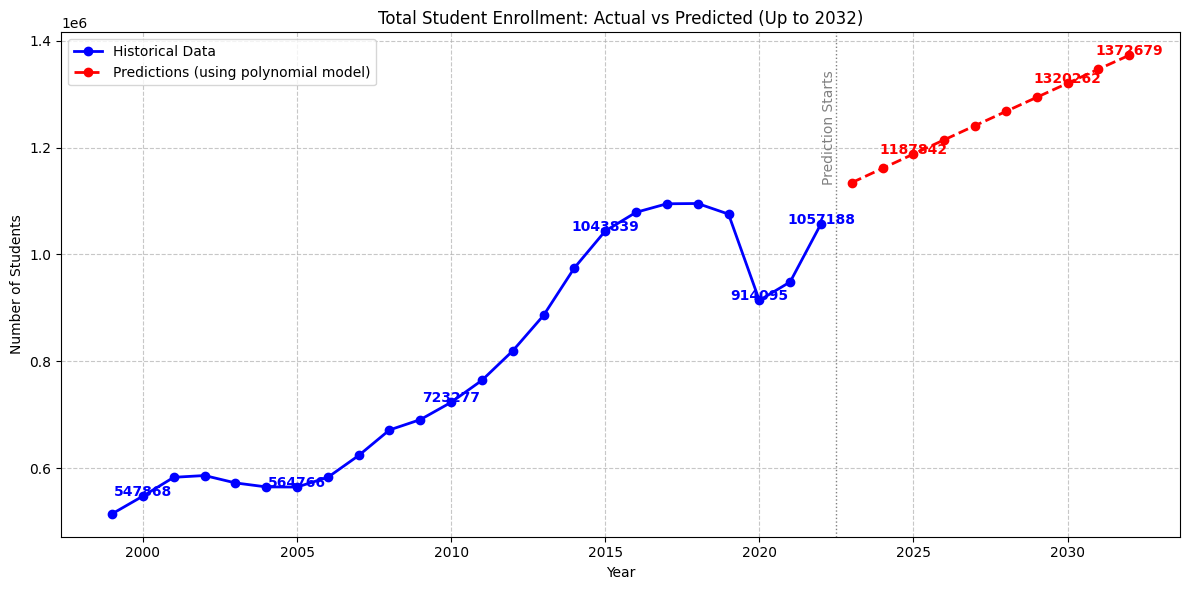

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv("academic_detail.csv")

# Create numeric year feature
df['year_numeric'] = df['year'].apply(lambda x: int(x.split('/')[0]))

# Group by year to get total student count
total_students_by_year = df.groupby('year_numeric')['students'].sum().reset_index()

# Format the year column to match the prediction output format
total_students_by_year['year'] = total_students_by_year['year_numeric'].apply(
    lambda x: f"{x}/{str(x+1)[-2:]}")

# Print the historical data to understand the trend
print("Historical Data:")
print(total_students_by_year)

# Create features for model
X = total_students_by_year[['year_numeric']]
y = total_students_by_year['students']

# Try different models

# 1. Simple Linear Regression
linear_model = LinearRegression()
linear_model.fit(X, y)

# 2. Polynomial Regression (degree 2)
poly2_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly2_model.fit(X, y)

# Create future years up to 2032
latest_year = max(total_students_by_year['year_numeric'])
future_years = list(range(latest_year + 1, 2033))
future_X = pd.DataFrame(future_years, columns=['year_numeric'])

# Make predictions with both models
linear_preds = linear_model.predict(future_X)
poly2_preds = poly2_model.predict(future_X)

# Create output dataframe
predictions = pd.DataFrame({
    'year_numeric': future_years,
    'year': [f"{year}/{str(year+1)[-2:]}" for year in future_years],
    'linear_prediction': linear_preds,
    'polynomial_prediction': poly2_preds
})

linear_train_preds = linear_model.predict(X)
poly2_train_preds = poly2_model.predict(X)

linear_rmse = np.sqrt(mean_squared_error(y, linear_train_preds))
poly2_rmse = np.sqrt(mean_squared_error(y, poly2_train_preds))
linear_r2 = r2_score(y, linear_train_preds)
poly2_r2 = r2_score(y, poly2_train_preds)

print(f"\nLinear Model - RMSE: {linear_rmse:.2f}, R²: {linear_r2:.4f}")
print(f"Polynomial Model - RMSE: {poly2_rmse:.2f}, R²: {poly2_r2:.4f}")

# Choose best model based on R²
best_model = 'polynomial_prediction' if poly2_r2 > linear_r2 else 'linear_prediction'
predictions['predicted_total_students'] = np.round(predictions[best_model]).astype(int)

# Prepare historical data for the combined dataset
historical_for_combined = total_students_by_year[['year', 'year_numeric', 'students']].copy()
historical_for_combined.rename(columns={'students': 'enrollment'}, inplace=True)
historical_for_combined['data_type'] = 'Actual'

# Prepare predictions for the combined dataset
predictions_for_combined = predictions[['year', 'year_numeric', 'predicted_total_students']].copy()
predictions_for_combined.rename(columns={'predicted_total_students': 'enrollment'}, inplace=True)
predictions_for_combined['data_type'] = 'Predicted'

# Create the combined dataset
combined_data = pd.concat([
    historical_for_combined,
    predictions_for_combined
], ignore_index=True).sort_values('year_numeric')

# Visualize with clear distinction between actual and predicted
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(historical_for_combined['year_numeric'], historical_for_combined['enrollment'],
         color='blue', marker='o', linestyle='-', linewidth=2, label='Historical Data')

# Plot predictions
plt.plot(predictions_for_combined['year_numeric'], predictions_for_combined['enrollment'],
         color='red', marker='o', linestyle='--', linewidth=2, label=f'Predictions (using {best_model.split("_")[0]} model)')

# Add data labels for key years
for i, row in combined_data.iterrows():
    if row['year_numeric'] % 5 == 0 or row['year_numeric'] == latest_year or row['year_numeric'] == 2032:
        color = 'blue' if row['data_type'] == 'Actual' else 'red'
        plt.text(row['year_numeric'], row['enrollment'] + 100, f"{int(row['enrollment'])}",
                 ha='center', color=color, fontweight='bold')

plt.title('Total Student Enrollment: Actual vs Predicted (Up to 2032)')
plt.xlabel('Year')
plt.ylabel('Number of Students')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Add vertical line separating actual and predicted data
plt.axvline(x=latest_year + 0.5, color='gray', linestyle=':', linewidth=1)
plt.text(latest_year + 0.5, plt.ylim()[1] * 0.95, 'Prediction Starts',
         rotation=90, va='top', ha='right', color='gray')

# Save the visualization
plt.tight_layout()
plt.savefig('combined_total_enrollment_data.png', dpi=300, bbox_inches='tight')

# Save the combined dataset to CSV
combined_data.to_csv('combined_total_enrollment_data.csv', index=False)

# Statistics for comparison
actual_min = historical_for_combined['enrollment'].min()
actual_max = historical_for_combined['enrollment'].max()
actual_avg = historical_for_combined['enrollment'].mean()
actual_start = historical_for_combined.iloc[0]['enrollment']
actual_end = historical_for_combined.iloc[-1]['enrollment']
actual_growth = actual_end - actual_start

pred_min = predictions_for_combined['enrollment'].min()
pred_max = predictions_for_combined['enrollment'].max()
pred_avg = predictions_for_combined['enrollment'].mean()
pred_start = predictions_for_combined.iloc[0]['enrollment']
pred_end = predictions_for_combined.iloc[-1]['enrollment']
pred_growth = pred_end - pred_start

print("\nOutput Summary:")
print(f"1. Combined data saved to: combined_total_enrollment_data.csv")
print(f"2. Visualization saved to: combined_total_enrollment_data.png")

print("\nActual Data Statistics:")
print(f"  Years: {historical_for_combined['year_numeric'].min()} to {historical_for_combined['year_numeric'].max()}")
print(f"  Min: {actual_min}, Max: {actual_max}, Avg: {actual_avg:.1f}")
print(f"  Growth: {actual_growth} students ({actual_growth/actual_start*100:.1f}%)")

print("\nPredicted Data Statistics:")
print(f"  Years: {predictions_for_combined['year_numeric'].min()} to {predictions_for_combined['year_numeric'].max()}")
print(f"  Min: {pred_min}, Max: {pred_max}, Avg: {pred_avg:.1f}")
print(f"  Growth: {pred_growth} students ({pred_growth/pred_start*100:.1f}%)")

print("\nModel Performance:")
print(f"  Best model: {best_model.split('_')[0]}")
print(f"  {best_model.split('_')[0]} R²: {max(linear_r2, poly2_r2):.4f}")

# Display the plot
plt.show()